In [771]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from random import randint

In [772]:
def classBaies(x, B, M1, M2):
    # Омера большое в данном контексте это Q
    # P(Qi) = 0.5, так как 2 множества c одинаковым числом реализайций N
    x1 = np.linspace(min(x[0]), max(x[0]), len(x[0]))
    B_ = np.linalg.inv(B)
    a = (M1 - M2).T @ B_
    b = - 0.5 * (M1 + M2).T @ B_ @ (M1 - M2) + np.log(1)
    #print(a)
    
    x2 = -(a[0][0] * x1 + b) / a[0][1]
    #print(x2)
    return x1, x2

In [773]:
def classBaiesKvadratic(x, B1, B2, M1, M2,):
    """Граница байесовского классификатора для разных матриц ковариации"""
    # M1_T = M1.reshape(1, 2)
    # M2_T = M2.reshape(1, 2)

    B1_ = np.linalg.inv(B1)
    B2_ = np.linalg.inv(B2)

    det_B1 = np.linalg.det(B1)
    det_B2 = np.linalg.det(B2)

    A = 0.5 * (B2_ - B1_)
    b = M1.T @ B1_ - M2.T @ B2_
    c = (0.5 * (M2.T @ B2_ @ M2) - 0.5 * (M1.T @ B1_ @ M1) 
         + 0.5 * np.log(det_B2 / det_B1))

    coeff_y = (A[1][0] * x + A[0][1] * x + b[0][1]) / A[1][1]
    coeff_c = (A[0][0] * x * x + b[0][0] * x + c[0][0]) / A[1][1]

    D = np.power(coeff_y, 2) - 4 * 1 * coeff_c

    y1 = (- coeff_y[D >= 0] + np.sqrt(D[D >= 0])) / 2
    y2 = (- coeff_y[D >= 0] - np.sqrt(D[D >= 0])) / 2

    return x[D > 0], y1, y2

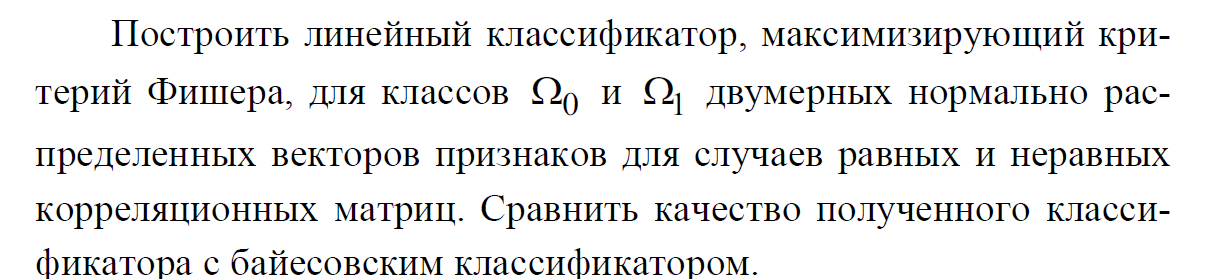

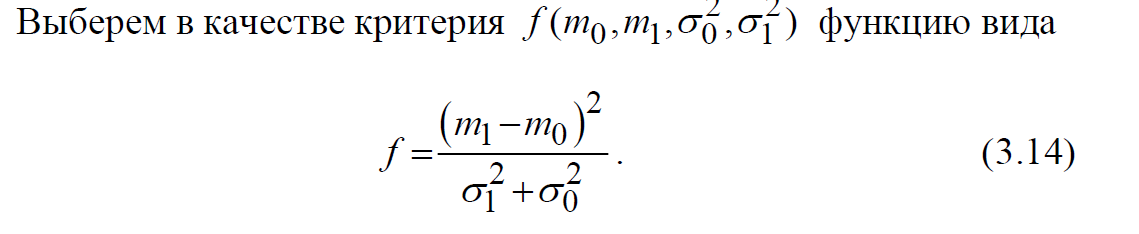

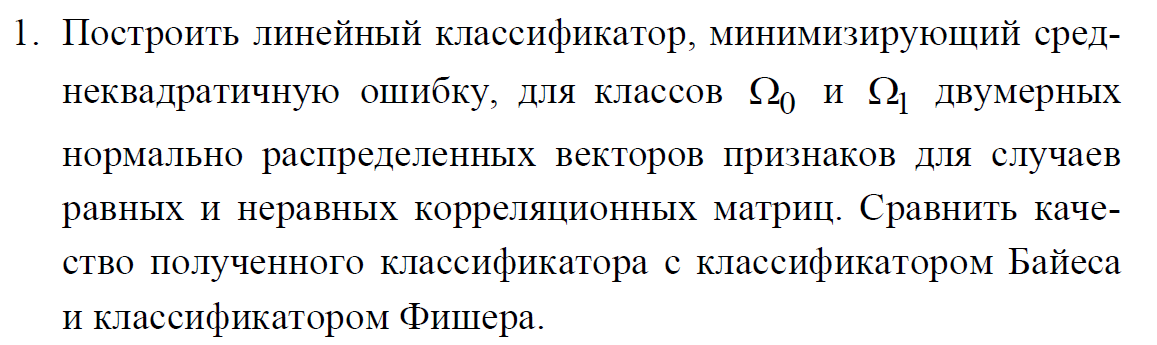
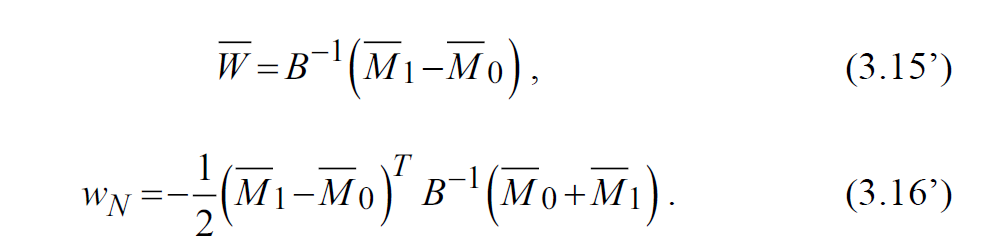
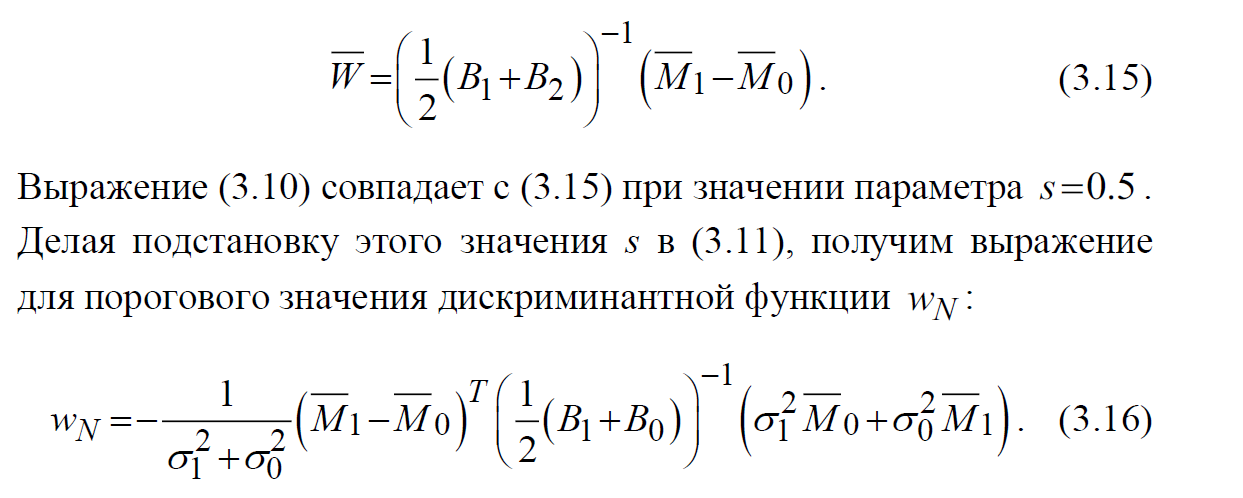

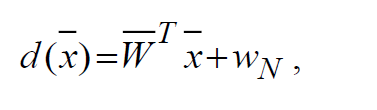

In [774]:
def Fisher(x, M0, B0, M1=0, B1=0, mode='same'):
    if mode == "same":
        B_ = np.linalg.inv(B0)
        W = (M1 - M0).T @ B_
        w_N = -0.5 * (M1 - M0).T @ B_ @ (M1 + M0)
        x1 = np.linspace(min(x[0]), max(x[0]),  len(x[0]))
        a = -W[0][0]/W[0][1]
        b = -w_N/W[0][1]
        x2 = a * x1 + b
        
    elif mode == "rather":
        W =  0.5 * np.linalg.inv(B0 + B1) @ (M1 - M0)

        s0 = W.T @ B0 @ W
        s1 = W.T @ B1 @ W
        w_N = - ((M1.T - M0.T) @ (0.5 * np.linalg.inv(B0 + B1)) @ (s1 * M0 + s0 * M1)) / (s0 + s1)
        x1 = np.linspace(min(x[0]), max(x[0]),  len(x[0]))
        a = -W[0]/W[1]
        b = -w_N/W[1]
        x2 = a * x1 + b
    else:
        print('Mode error')
    
    
    return x1, x2, a, b

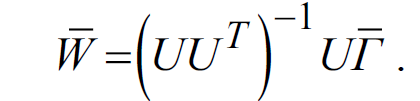

In [775]:
def minstd_classifier(x0, x1, x):
    """
    Классификатор минимизации СКО (по слайдам).
    X0: (n0, 2) — объекты класса Ω0
    X1: (n1, 2) — объекты класса Ω1
    Возвращает:
        w: (2,) — веса при признаках
        b: float — порог (смещение)
    """
    n0 = x0.shape[1]
    n1 = x1.shape[1]

    # z = [x1, x2, 1]; для Ω0 умножаем на -1
    z0 = -np.column_stack([x0.T, np.ones(n0)])   # Ω0 -> минус
    z1 =  np.column_stack([x1.T, np.ones(n1)])   # Ω1 -> плюс

    U = np.vstack([z1, z0])                     # K×3 (K = n0 + n1)
    Gamma = np.ones((U.shape[0], 1))            # Γ ≡ 1

    # Решение МНК: W = argmin ||U W - Γ||^2
    # (равносильно (U^T U)^(-1) U^T Γ, но lstsq стабильнее)
    W, _, _, _ = np.linalg.lstsq(U, Gamma, rcond=None)

    w = W[:2, 0]                                    # первые два коэффициента
    b = -W[2, 0]/ w[1]                                     # смещение (при столбце единиц)
    a = -w[0]/w[1]
    y = a * x + b
    return y, a, b

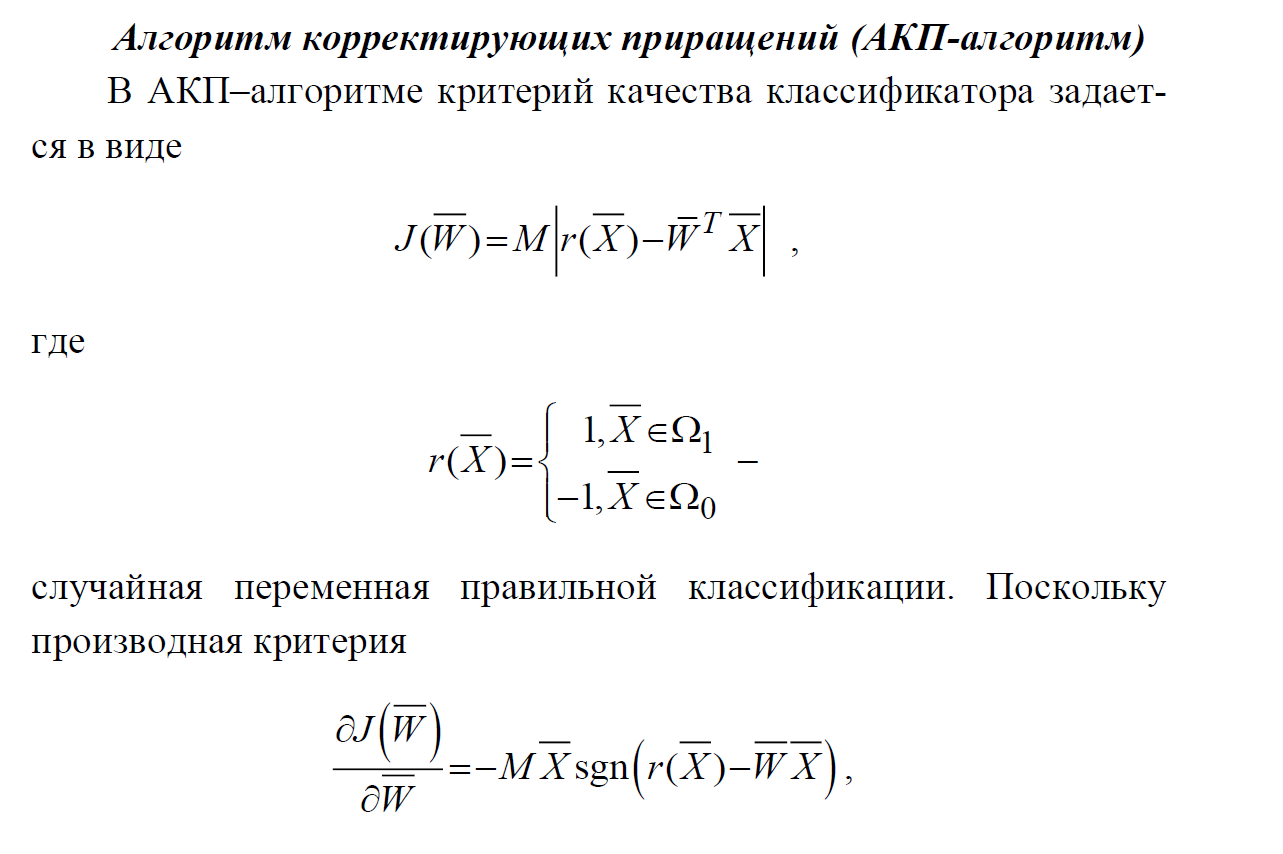

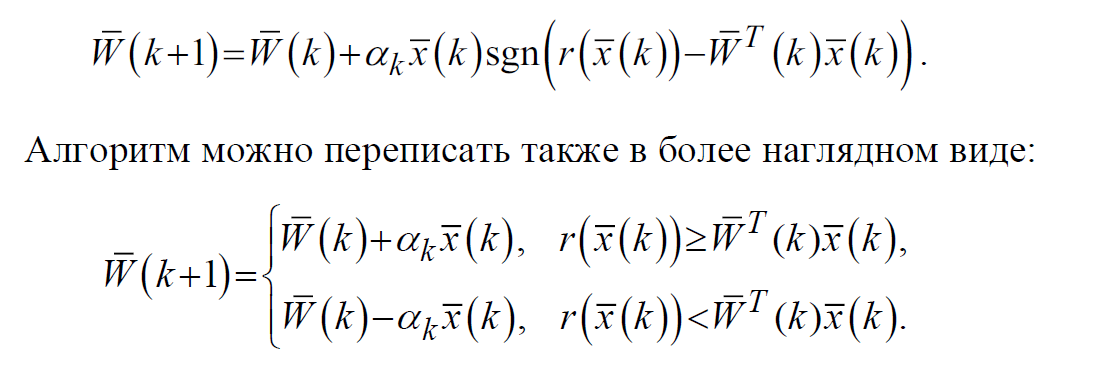

In [776]:
def shuffle(a: list):
    b = a.copy()
    n = len(a)
    for i in range(n-1):
        r = randint(i+1, n-1)
        b[i], b[r] = b[r], b[i]
    return b

def ACP_classifier(x0, x1, x_, W0=np.array([[1.0, 1.0, 1.0]]).T, max_iterations=1000, beta=0.9):
    """Алгоритм Роббинса-Монро (стохастическая аппроксимация).
       x0, x1 имеют форму (2, n)
    """
    # --- Подготовка данных: (2,n) -> (n,2) и корректные единицы/метки ---
    n0 = x0.shape[1]
    n1 = x1.shape[1]
    z0 = np.column_stack([x0.T, np.ones(n0), -1 * np.ones(n0)])  # [x, y, 1, -1]
    z1 = np.column_stack([x1.T, np.ones(n1),  1 * np.ones(n1)])  # [x, y, 1,  1]

    z = np.vstack([z0, z1])     # (K,4)
    z_data = z[:, :3].T         # (3,K) признаки [x, y, 1]
    z_labels = z[:, 3]          # (K,)   метки r ∈ {−1,+1}

    # --- Инициализация ---
    W = W0.copy()
    Warr = [W.copy()]
    n_samples = z_data.shape[1]

    k = 0
    iter = 0
    for iteration in range(max_iterations):
        # Перемешиваем данные на каждой итерации
        indices = shuffle(list(range(n_samples)))
        for i in range(n_samples):
            j = indices[i]
            alpha = 1 / (k + 1) ** beta
            k += 1

            xi = z_data[:, j:j+1]                # Вектор признаков
            r  = z_labels[j]                     # Правильный класс
            W = W + alpha * xi * np.sign(r - float(W.T @ xi))

        Warr.append(W.copy())
        
        if np.linalg.norm(Warr[-1] - Warr[-2]) < 1e-3:
            iter = iteration
            break

    # --- Линия решения: w0*x + w1*y + w2 = 0 -> y(x) = -(w0*x + w2)/w1 ---
    w0, w1, w2 = Warr[-1].ravel()
    a = -w0/w1
    b = -w2/w1
    y = a * x_ + b

    return y, a, b, iter

In [777]:
def calculate_error(v1, v2, a, b):
    p0_exp = 0
    p1_exp = 0
    for x, y in zip(v1[0], v1[1]):
        if y >= a * x + b:
            p0_exp += 1/len(v1[0])
            
    for x, y in zip(v2[0], v2[1]):
        if y < a * x + b:
            p1_exp += 1/len(v2[0])
    
    return p0_exp, p1_exp

In [778]:
dir = "./vectors/"
M1 = np.load(dir + 'M_1.npy')
M2 = np.load(dir + 'M_2.npy')
B = np.load(dir + 'B.npy')

x1_1 = np.load(dir + 'x1_1.npy')
x1_2 = np.load(dir + 'x1_2.npy')

xlim_s = [min(min(x1_1[0]), min(x1_2[0])) - 1, max(max(x1_1[0]), max(x1_2[0])) + 1]
ylim_s = [min(min(x1_1[1]), min(x1_2[1])) - 1, max(max(x1_1[1]), max(x1_2[1])) + 1]
x_linespase_s = np.linspace(*xlim_s, 500)



Классификатор Фишера

y = -1.77*x + -1.16

Классификатор минимизации СКО

y = -1.79*x + -1.28

Классификатор Робинса-Миллера

Сходимость достигнута за 49 итераций
y = -1.78*x + -1.25


C:\Users\Marishka\AppData\Local\Temp\ipykernel_13456\2975769678.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W = W + alpha * xi * np.sign(r - float(W.T @ xi))


Text(0.5, 1.0, 'X1 и X2 с равной корреляцией')

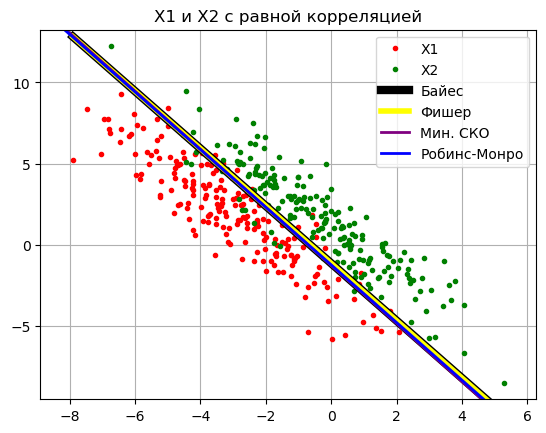

In [779]:
x_b_ravn, y_baies = classBaies(np.hstack((x1_1, x1_2)), B, M1, M2)
x_fisher_ravn, y_fisher_ravn, a, b = Fisher(x = np.hstack((x1_1, x1_2)), M0 = M1, B0 = B, M1 = M2, mode='same')
print(f'\nКлассификатор Фишера\n')
print(f'y = {a:.2f}*x + {b[0][0]:.2f}')
p0_f_s, p1_f_s = calculate_error(x1_1, x1_2, a, b)


y_min_SKO_ravn, a, b = minstd_classifier(x1_1, x1_2, x_linespase_s)
print(f'\nКлассификатор минимизации СКО\n')
print(f'y = {a:.2f}*x + {b:.2f}')
p0_sko_s, p1_sko_s = calculate_error(x1_1, x1_2, a, b)


y_robin_ravn, a, b, iter = ACP_classifier(x1_1, x1_2, x_linespase_s)
print(f'\nКлассификатор Робинса-Миллера\n')
print(f"Сходимость достигнута за {iter} итераций")
print(f'y = {a:.2f}*x + {b:.2f}')
p0_rm_s, p1_rm_s = calculate_error(x1_1, x1_2, a, b)

plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x_b_ravn, y_baies[0], color='black', linewidth = 6)
plt.plot(x_fisher_ravn, y_fisher_ravn[0], color='yellow', linewidth = 4)
plt.plot(x_linespase_s, y_min_SKO_ravn, color='purple', linewidth = 2)
plt.plot(x_linespase_s, y_robin_ravn, color='blue', linewidth = 2)
plt.xlim(*xlim_s)
plt.ylim(*ylim_s)
plt.grid(True)

plt.legend(['X1', 'X2', 'Байес', 'Фишер', 'Мин. СКО', 'Робинс-Монро'])
plt.title('X1 и X2 с равной корреляцией')

In [780]:
print(f"\nЭкспериментальные ошибки Фишера")
print(f"p0 = {p0_f_s}")
print(f"p1 = {p1_f_s}")

print(f"\nЭкспериментальные ошибки при минимизации СКО")
print(f"p0 = {p0_sko_s}")
print(f"p1 = {p1_sko_s}")

print(f"\nЭкспериментальные ошибки Робинса-Миллера")
print(f"p0 = {p0_rm_s}")
print(f"p1 = {p1_rm_s}")


Экспериментальные ошибки Фишера
p0 = 0.06999999999999999
p1 = 0.075

Экспериментальные ошибки при минимизации СКО
p0 = 0.06999999999999999
p1 = 0.075

Экспериментальные ошибки Робинса-Миллера
p0 = 0.06999999999999999
p1 = 0.075


In [781]:
dir = "./vectors/"
M1 = np.load(dir + 'M_1.npy')
M2 = np.load(dir + 'M_2.npy')

B1 = np.load(dir + 'B_1.npy')
B2 = np.load(dir + 'B_2.npy')

x2_1 = np.load(dir + 'x2_1.npy')
x2_2 = np.load(dir + 'x2_2.npy')

xlim_r = [min(min(x2_1[0]), min(x2_2[0])) - 1, max(max(x2_1[0]), max(x2_2[0])) + 1]
ylim_r = [min(min(x2_1[1]), min(x2_2[1])) - 1, max(max(x2_1[1]), max(x2_2[1])) + 1]
x_linespase_r = np.linspace(*xlim_r, 500)


Классификатор Фишера

y = 0.76*x + 1.99

Классификатор минимизации СКО

y = 0.75*x + 2.61

Классификатор Робинса-Миллера

Сходимость достигнута за 30 итераций
y = 0.81*x + 2.79


C:\Users\Marishka\AppData\Local\Temp\ipykernel_13456\2975769678.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W = W + alpha * xi * np.sign(r - float(W.T @ xi))


Text(0.5, 1.0, 'X1 и X2 с разной корреляцией')

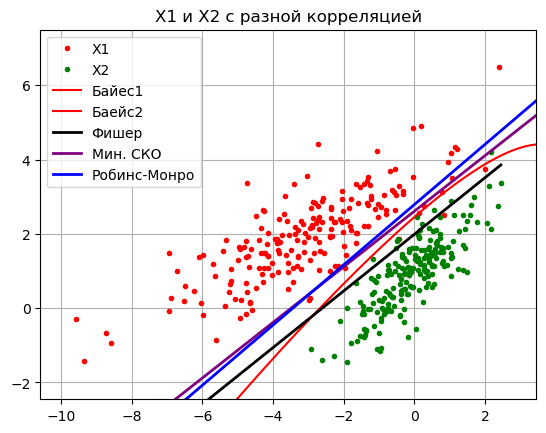

In [782]:
x_b_rather, y_b_rather, d_b_rather = classBaiesKvadratic(x_linespase_r, B1, B2, M1, M2)
x_fisher_raher, y_fisher_rather, a, b = Fisher(x = np.hstack((x2_1, x2_2)), M0 = M1, B0 = B1, M1 = M2, B1 = B2, mode='rather')
print(f'\nКлассификатор Фишера\n')
print(f'y = {a[0]:.2f}*x + {b[0][0]:.2f}')
p0_f_r, p1_f_r = calculate_error(x2_2, x2_1, a, b)


y_min_SKO_rather, a, b = minstd_classifier(x2_1, x2_2, x_linespase_r)
print(f'\nКлассификатор минимизации СКО\n')
print(f'y = {a:.2f}*x + {b:.2f}')
p0_sko_r, p1_sko_r = calculate_error(x2_2, x2_1, a, b)


y_robin_rather, a, b, iter = ACP_classifier(x2_1, x2_2, x_linespase_r)
print(f'\nКлассификатор Робинса-Миллера\n')
print(f"Сходимость достигнута за {iter} итераций")
print(f'y = {a:.2f}*x + {b:.2f}')
p0_rm_r, p1_rm_r = calculate_error(x2_2, x2_1, a, b)

plt.plot(x2_1[0,:], x2_1[1,:], color='red', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x2_2[0,:], x2_2[1,:], color='green', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x_b_rather, y_b_rather, color='red')
plt.plot(x_b_rather, d_b_rather, color='red')
plt.plot(x_fisher_raher, y_fisher_rather[0], color='black', linewidth = 2)
plt.plot(x_linespase_r, y_min_SKO_rather, color='purple', linewidth = 2)
plt.plot(x_linespase_r, y_robin_rather, color='blue', linewidth = 2)


plt.xlim(*xlim_r)
plt.ylim(*ylim_r)
plt.grid(True)

plt.legend(['X1', 'X2', 'Байес1', 'Баейс2', 'Фишер', 'Мин. СКО', 'Робинс-Монро'])
plt.title('X1 и X2 с разной корреляцией')

In [783]:
print(f"\nЭкспериментальные ошибки Фишера")
print(f"p0 = {p0_f_r}")
print(f"p1 = {p1_f_r}")

print(f"\nЭкспериментальные ошибки при минимизации СКО")
print(f"p0 = {p0_sko_r}")
print(f"p1 = {p1_sko_r}")

print(f"\nЭкспериментальные ошибки Робинса-Миллера")
print(f"p0 = {p0_rm_r}")
print(f"p1 = {p1_rm_r}")


Экспериментальные ошибки Фишера
p0 = 0.049999999999999996
p1 = 0.005

Экспериментальные ошибки при минимизации СКО
p0 = 0
p1 = 0.045

Экспериментальные ошибки Робинса-Миллера
p0 = 0
p1 = 0.05499999999999999


In [784]:
def iter_ACP_classifier(x0, x1, x_, W0=np.array([[1.0, 1.0, 1.0]]).T, max_iterations=1000, beta=0.5):
    """Алгоритм Роббинса-Монро (стохастическая аппроксимация).
       x0, x1 имеют форму (2, n)
    """
    # --- Подготовка данных: (2,n) -> (n,2) и корректные единицы/метки ---
    n0 = x0.shape[1]
    n1 = x1.shape[1]
    z0 = np.column_stack([x0.T, np.ones(n0), -1 * np.ones(n0)])  # [x, y, 1, -1]
    z1 = np.column_stack([x1.T, np.ones(n1),  1 * np.ones(n1)])  # [x, y, 1,  1]

    z = np.vstack([z0, z1])     # (K,4)
    z_data = z[:, :3].T         # (3,K) признаки [x, y, 1]
    z_labels = z[:, 3]          # (K,)   метки r ∈ {−1,+1}

    # --- Инициализация ---
    W = W0.copy()
    Warr = [W.copy()]
    n_samples = z_data.shape[1]

    k = 0
    iter = max_iterations
    for iteration in range(max_iterations):
        # Перемешиваем данные на каждой итерации
        indices = shuffle(list(range(n_samples)))
        for i in range(n_samples):
            j = indices[i]
            alpha = 1 / (k + 1) ** beta
            k += 1

            xi = z_data[:, j:j+1]                # Вектор признаков
            r  = z_labels[j]                     # Правильный класс
            W = W + alpha * xi * np.sign(r - float(W.T @ xi))

        Warr.append(W.copy())
        
        w0, w1, w2 = Warr[-1].ravel()
        a = -w0/w1
        b = -w2/w1
        y = a * x_ + b
        plt.plot(x_, y, linewidth = 1)
        
        if np.linalg.norm(Warr[-1] - Warr[-2]) < 1e-3:
            iter = iteration
            break

    w0, w1, w2 = Warr[-1].ravel()
    a = -w0/w1
    b = -w2/w1
    y = a * x_ + b
    
    plt.plot(x_, y, color='red', linewidth = 4)
    return iter

In [ ]:
plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none')  # plot saved and loaded data
plt.xlim(*xlim_s)
plt.ylim(*ylim_s)
iter = iter_ACP_classifier(x1_1, x1_2, x_linespase_r, beta=0.7)
print(f"Сходимость достигнута за {iter} итераций")

C:\Users\Marishka\AppData\Local\Temp\ipykernel_13456\2072058627.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  W = W + alpha * xi * np.sign(r - float(W.T @ xi))
